In [1]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import time
# import subprocess
import random

In [2]:
%matplotlib inline

## Utils

In [3]:
def alter_coord(action, position, g_coord, dx=0.1, change_nodes=list(range(1,9))):
        
    if action==0:
        g_coord[int(2*change_nodes[position])]+=dx
        g_coord[int(2*change_nodes[position])+1]+=dx
    elif action==1:
        g_coord[int(2*change_nodes[position])]+=dx
        g_coord[int(2*change_nodes[position])+1]-=dx
    if action==2:
        g_coord[int(2*change_nodes[position])]-=dx
        g_coord[int(2*change_nodes[position])+1]+=dx
    elif action==3:
        g_coord[int(2*change_nodes[position])]-=dx
        g_coord[int(2*change_nodes[position])+1]-=dx    
    elif action==4:
        g_coord[int(2*change_nodes[position])+1]-=0
             
    return g_coord

In [4]:
# this function must be tailored to different FE models
def observe(position, coord, displ):    
    return position, coord[0], coord[1],coord[2], coord[3], coord[4], coord[5],coord[6], \
coord[7], coord[8], coord[9],coord[10], coord[11], coord[12], coord[13],coord[14], coord[15],\
coord[16], coord[17],coord[18], coord[19], np.max(abs(displ))


#np.sum(abs(displ))

#displ[2]

# displ[0],displ[1],displ[2],displ[3],displ[4],\
# displ[5],displ[6],displ[7],displ[8],displ[9],displ[10],displ[11],displ[12],displ[13],\
# displ[14],displ[15],displ[16],displ[17],displ[18],displ[19],displ[20],displ[21],\
# displ[22],displ[23],displ[24],displ[25],displ[26],displ[27],displ[28],displ[29]

## Finite Element Model of the Plane Truss structure

In [5]:
def PlaneFrameElementLength(x1,y1,x2,y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))

In [6]:
def PlaneFrameElementStiffness(E,A,I,L,theta):
    pi=3.14159265   
    x = theta*pi/180
    C = math.cos(x)
    S = math.sin(x)
    w1 = A*C*C + 12*I*S*S/(L*L)
    w2 = A*S*S + 12*I*C*C/(L*L)
    w3 = (A-12*I/(L*L))*C*S
    w4 = 6*I*S/L
    w5 = 6*I*C/L
    
    return E/L*np.array([[w1, w3, -w4, -w1, -w3, -w4],[ w3, w2, w5, -w3, -w2, w5],
                        [-w4, w5, 4*I, w4, -w5, 2*I],[ -w1, -w3, w4, w1, w3, w4],
                        [-w3, -w2, -w5, w3, w2, -w5], [-w4, w5, 2*I, w4, -w5, 4*I]])    

In [7]:
def PlaneFrameAssemble(K,k,i,j):
    K[3*i,3*i] = K[3*i,3*i] + k[0,0]
    K[3*i,3*i+1] = K[3*i,3*i+1] + k[0,1]    
    K[3*i,3*i+2] = K[3*i,3*i+2] + k[0,2]
    K[3*i,3*j] = K[3*i,3*j] + k[0,3]
    K[3*i,3*j+1] = K[3*i,3*j+1] + k[0,4]
    K[3*i,3*j+2] = K[3*i,3*j+2] + k[0,5]
    K[3*i+1,3*i] = K[3*i+1,3*i] + k[1,0]
    K[3*i+1,3*i+1] = K[3*i+1,3*i+1] + k[1,1]
    K[3*i+1,3*i+2] = K[3*i+1,3*i+2] + k[1,2]
    K[3*i+1,3*j] = K[3*i+1,3*j] + k[1,3]
    K[3*i+1,3*j+1] = K[3*i+1,3*j+1] + k[1,4]
    K[3*i+1,3*j+2] = K[3*i+1,3*j+2] + k[1,5]
    K[3*i+2,3*i] = K[3*i+2,3*i] + k[2,0]
    K[3*i+2,3*i+1] = K[3*i+2,3*i+1] + k[2,1]
    K[3*i+2,3*i+2] = K[3*i+2,3*i+2] + k[2,2]
    K[3*i+2,3*j] = K[3*i+2,3*j] + k[2,3]
    K[3*i+2,3*j+1] = K[3*i,3*j+1] + k[2,4]
    K[3*i+2,3*j+2] = K[3*i+2,3*j+2] + k[2,5]
    K[3*j,3*i] = K[3*j,3*i] + k[3,0]
    K[3*j,3*i+1] = K[3*j,3*i+1] + k[3,1]
    K[3*j,3*i+2] = K[3*j,3*i+2] + k[3,2]
    K[3*j,3*j] = K[3*j,3*j] + k[3,3]
    K[3*j,3*j+1] = K[3*j,3*j+1] + k[3,4]
    K[3*j,3*j+2] = K[3*j,3*j+2] + k[3,5]   
    K[3*j+1,3*i] = K[3*j+1,3*i] + k[4,0]
    K[3*j+1,3*i+1] = K[3*j+1,3*i+1] + k[4,1]
    K[3*j+1,3*i+2] = K[3*j+1,3*i+2] + k[4,2]
    K[3*j+1,3*j] = K[3*j+1,3*j] + k[4,3]
    K[3*j+1,3*j+1] = K[3*j+1,3*j+1] + k[4,4]
    K[3*j+1,3*j+2] = K[3*j+1,3*j+2] + k[4,5]
    K[3*j+2,3*i] = K[3*j+2,3*i] + k[5,0]
    K[3*j+2,3*i+1] = K[3*j+2,3*i+1] + k[5,1]
    K[3*j+2,3*i+2] = K[3*j+2,3*i+2] + k[5,2]
    K[3*j+2,3*j] = K[3*j+2,3*j] + k[5,3]
    K[3*j+2,3*j+1] = K[3*j+2,3*j+1] + k[5,4]
    K[3*j+2,3*j+2] = K[3*j+2,3*j+2] + k[5,5]
    
    return K

In [8]:
def FEA_u(coord, elcon, bc_u_elim, f_after_u_elim, I=5e-5, A=1e-4, E=210e6):
    K=np.zeros(shape=(3*np.max(elcon)+3,3*np.max(elcon)+3))
    pi=3.14159265
    for el in elcon:
        L=PlaneFrameElementLength(coord[el[0]][0],coord[el[0]][1],coord[el[1]][0],coord[el[1]][1])
        theta=math.atan((coord[el[1]][1]-coord[el[0]][1])/(coord[el[1]][0]-coord[el[0]][0]+1e-13))*180/pi
        k=PlaneFrameElementStiffness(E,A,I,L,theta)
        K=PlaneFrameAssemble(K,k,el[0],el[1])
    K=np.delete(K,bc_u_elim,0)
    K=np.delete(K,bc_u_elim,1)
    

    d=np.dot(np.linalg.inv(K),f_after_u_elim)
    ans=np.zeros(shape=(3*len(coord)))

    j=0
    for i in range(len(ans)):
        if i not in bc_u_elim:
            ans[i]=d[j]
            j+=1
            if j>len(d)-1:
                break
    return ans

## Neural Network Policy - Policy Gradients

In [9]:
# Details of model can be found in the book:
# Hands-On Machine Learning with Scikit-Learn & TensorFlow. Aurйlien Gйron

In [10]:
# the NN architecture must be tailored to different FE models

In [11]:
n_inputs = 22 
n_hidden = 70 
n_outputs = 5 
initializer = tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.001

# Build the neural network
X_ = tf.placeholder(tf.float64, shape=[None, n_inputs], name="X_")
hidden = fully_connected(X_, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
hidden1 = fully_connected(hidden, n_hidden, activation_fn=tf.nn.elu, weights_initializer=initializer)
logits = fully_connected(hidden1, n_outputs, activation_fn=None, weights_initializer=initializer)
outputs = tf.nn.softmax(logits, name="Y_proba")

# Select a random action based on the estimated probabilities
action = tf.multinomial(tf.log(outputs), num_samples=1,output_dtype=tf.int32)

y=tf.reshape(tf.one_hot(action,depth=5,dtype=tf.float64),[5,1])
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=tf.transpose(logits))

optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(xentropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float64, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.random.categorical` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
def discount_rewards(rewards, discount_rate=0.97):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

In [13]:
def discount_and_normalize_rewards(all_rewards, discount_rate=0.97):
    all_discounted_rewards = [discount_rewards(rewards) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [14]:
# this function must be tailored to different FE models

def reward_(obs_,obs): 
#     if np.max(abs(np.array(obs_[22:-1])))>np.max(abs(np.array(obs[22:-1]))): 
#     if sum(abs(np.array(obs_[22:-1])))>sum(abs(np.array(obs[22:-1]))):
#     return sum(abs(np.array(obs_[22:-1]))>abs(np.array(obs[22:-1]))) 

#     if abs(obs_[-1])>abs(obs[-1]):
    if obs_[-1]>obs[-1]:
        return 1
    else:
        return 0

In [15]:
# the training code must be tailored to different FE models

In [16]:
n_iterations =101 #251  # number of training iterations
n_max_steps = 500 #1000  # max steps per episode
n_games_per_update = 10 # train the policy every 10 episodes
save_iterations = 5 # save the model every 10 training iterations


with tf.Session() as sess:
    start=time.time()
    init.run() 
    
#     saver.restore(sess, tf.train.latest_checkpoint("./policy4/"))    
#     tf.get_default_graph()
    
    for iteration in range(n_iterations):
               
        all_rewards = [] # all sequences of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode
             
        for game in range(n_games_per_update):
            current_rewards = [] # all raw rewards from the current episode
            current_gradients = [] # all gradients from the current episode
            
            pst=random.randint(0,7)
            g_coord = alter_coord(4, pst, np.array([0.0,0,3,0,6,0,9,0,9,3,9,6,9,9,12,9,15,9,18,9]),
                                          dx=0.1, change_nodes=list(range(1,9)))
            
            
            displ = FEA_u(g_coord.reshape(10,2), elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]),
                                                    bc_u_elim=[0,1,2],
                                                    f_after_u_elim=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-10,0,0]), 
                                                    I=5e-5, A=2e-2, E=210e6)
            
            obs=observe(pst, g_coord,displ)
            
            
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients],
                                                     feed_dict={X_: np.array(obs).reshape(1,n_inputs)}) 
                obs_=obs        
                g_coord = alter_coord(action_val[0][0], pst, g_coord,
                                          dx=0.1, change_nodes=list(range(1,9)))
                
                pst=random.randint(0,7)
                
                if PlaneFrameElementLength(g_coord[0],g_coord[1],g_coord[2],g_coord[3])<0.02:
                    break
            
                if PlaneFrameElementLength(g_coord[2],g_coord[3],g_coord[4],g_coord[5])<0.02:
                    break
             
                if PlaneFrameElementLength(g_coord[4],g_coord[5],g_coord[6],g_coord[7])<0.02:
                    break
            
                if PlaneFrameElementLength(g_coord[6],g_coord[7],g_coord[8],g_coord[9])<0.02:
                    break
            
                if PlaneFrameElementLength(g_coord[8],g_coord[9],g_coord[10],g_coord[11])<0.02:
                    break
            
             
                if PlaneFrameElementLength(g_coord[10],g_coord[11],g_coord[12],g_coord[13])<0.02:
                    break
            
                if PlaneFrameElementLength(g_coord[12],g_coord[13],g_coord[14],g_coord[15])<0.02:
                    break
            
                if PlaneFrameElementLength(g_coord[14],g_coord[15],g_coord[16],g_coord[17])<0.02:
                    break
            
                if PlaneFrameElementLength(g_coord[16],g_coord[17],g_coord[18],g_coord[19])<0.02:
                    break
                            
                
                displ = FEA_u(g_coord.reshape(10,2), elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]),
                                                    bc_u_elim=[0,1,2],
                                                    f_after_u_elim=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-10,0,0]), 
                                                    I=5e-5, A=2e-2, E=210e6)
                
                
                
                
                
                obs=observe(pst,g_coord,displ) 
                
                reward=reward_(obs_,obs)
                
                current_rewards.append(reward)
                current_gradients.append(gradients_val)

            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

    
            
        # At this point we have run the policy for 10 episodes, and we are
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards)
        
        
        
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index] 
                                      for game_index, rewards in enumerate(all_rewards)
                                      for step, reward in enumerate(rewards)],axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        
        
        sess.run(training_op, feed_dict=feed_dict)
        
        if iteration % save_iterations == 0:
#             print("Saving {} iteration".format(iteration))
            print('Time taken for {} epoch {} sec\n'.format(iteration, time.time() - start))
            saver.save(sess, "./policy4/pinjointed4.ckpt")

# end=time.time()            

Time taken for 0 epoch 42.31264090538025 sec

Time taken for 5 epoch 198.13890194892883 sec

Time taken for 10 epoch 350.52830386161804 sec

Time taken for 15 epoch 511.6054878234863 sec

Time taken for 20 epoch 668.9204878807068 sec

Time taken for 25 epoch 790.1450479030609 sec

Time taken for 30 epoch 924.8818118572235 sec

Time taken for 35 epoch 1044.5332617759705 sec

Time taken for 40 epoch 1148.6496307849884 sec

Time taken for 45 epoch 1266.6734147071838 sec

Time taken for 50 epoch 1396.3372757434845 sec

Time taken for 55 epoch 1523.156457901001 sec

Time taken for 60 epoch 1655.6883237361908 sec

Time taken for 65 epoch 1767.5107808113098 sec

Time taken for 70 epoch 1868.1316769123077 sec

Time taken for 75 epoch 1968.3633208274841 sec

Time taken for 80 epoch 2039.800969839096 sec

Time taken for 85 epoch 2110.7327926158905 sec

Time taken for 90 epoch 2192.7845458984375 sec

Time taken for 95 epoch 2265.571138858795 sec

Time taken for 100 epoch 2344.6355748176575 sec



In [17]:
# print(end-start)

## AI designing the spool

In [18]:
def predict(coord):
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('./policy4/pinjointed4.ckpt.meta')
        saver.restore(sess, "./policy4/pinjointed4.ckpt") 

        graph = tf.get_default_graph()
        outputs = graph.get_tensor_by_name("Y_proba:0") 
        X_ = graph.get_tensor_by_name("X_:0") 
                
#         pst=random.randint(0,7)
        
        j=0
        pst=j%8
        g_coord = alter_coord(4, pst, coord, dx=0.1, change_nodes=list(range(1,9)))
            
        displ = FEA_u(g_coord.reshape(10,2), elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]),
                                                    bc_u_elim=[0,1,2],
                                                    f_after_u_elim=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-10,0,0]), 
                                                    I=5e-5, A=2e-2, E=210e6)
            
        obs=observe(pst, g_coord,  displ)       
        
        print("before: ", np.max(abs(displ)))
        
        for step in range(50):
            action_val= sess.run([outputs],feed_dict={X_: np.array(obs).reshape(1,n_inputs)})
            
            action_val=np.log(action_val)
            g_coord = alter_coord( np.argmax(action_val), pst, g_coord, dx=0.1, change_nodes=list(range(1,9)))
            
            
#             print(pst)
#             pst=random.randint(0,7)
            j+=1
            pst=j%8
        
            if PlaneFrameElementLength(g_coord[0],g_coord[1],g_coord[2],g_coord[3])<0.02:
                break
            
            if PlaneFrameElementLength(g_coord[2],g_coord[3],g_coord[4],g_coord[5])<0.02:
                break
             
            if PlaneFrameElementLength(g_coord[4],g_coord[5],g_coord[6],g_coord[7])<0.02:
                break
            
            if PlaneFrameElementLength(g_coord[6],g_coord[7],g_coord[8],g_coord[9])<0.02:
                break
            
            if PlaneFrameElementLength(g_coord[8],g_coord[9],g_coord[10],g_coord[11])<0.02:
                break
                
            if PlaneFrameElementLength(g_coord[10],g_coord[11],g_coord[12],g_coord[13])<0.02:
                break
            
            if PlaneFrameElementLength(g_coord[12],g_coord[13],g_coord[14],g_coord[15])<0.02:
                break
            
            if PlaneFrameElementLength(g_coord[14],g_coord[15],g_coord[16],g_coord[17])<0.02:
                break
            
            if PlaneFrameElementLength(g_coord[16],g_coord[17],g_coord[18],g_coord[19])<0.02:
                break
            
            
            
            
            

            displ = FEA_u(g_coord.reshape(10,2), elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]),
                                                    bc_u_elim=[0,1,2],
                                                    f_after_u_elim=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-10,0,0]), 
                                                    I=5e-5, A=2e-2, E=210e6)
            
            obs=observe(pst, g_coord, displ)
        print("after: ", np.max(abs(displ)))
#         print("after: ", abs(displ[2]))
        return obs,g_coord        

In [19]:
obs, g_coord = predict(np.array([0.0,0,3,0,6,0,9,0,9,3,9,6,9,9,12,9,15,9,18,9]))

INFO:tensorflow:Restoring parameters from ./policy4/pinjointed4.ckpt
before:  1.3885714292728
after:  0.17816316274978494


In [20]:
g_coord

array([ 0. ,  0. ,  2.3, -0.7,  5.3, -0.7,  8.4, -0.6,  8.4,  2.4,  8.4,
        5.4,  8.4,  8.4, 11.4,  8.4, 14.4,  8.4, 18. ,  9. ])

In [21]:
import matplotlib.pyplot as plt

In [22]:
def draw(coord,color,elcon):
    coord=coord.reshape(np.max(elcon)+1,2)
    plt.figure(figsize=(13,5))
    for item in elcon:
        plt.plot([coord[item[0]][0],coord[item[1]][0]],[coord[item[0]][1],coord[item[1]][1]],color=color)
       
    plt.show()    

### Initial Design 

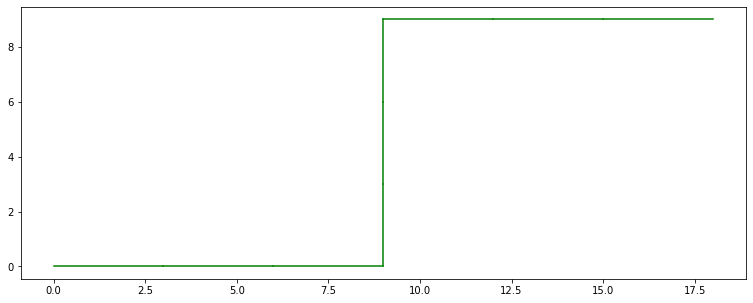

In [23]:
draw(np.array([0,0,3,0,6,0,9,0,9,3,9,6,9,9,12,9,15,9,18,9]),color="green",elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]))

### Design by AI

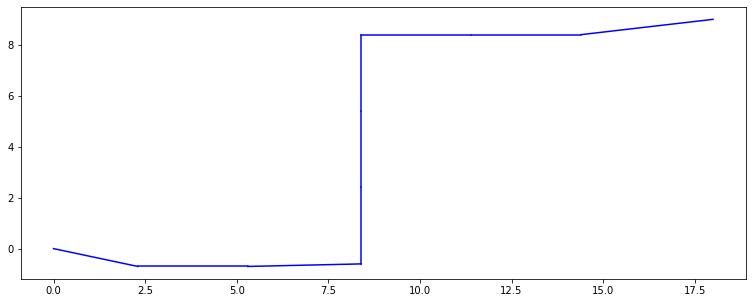

In [24]:
draw(g_coord,color="blue",elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]))